### National Institute for Space Research</h5>
   <img src="img/icone_cap394.svg" align="right" alt="Drawing" style="width: 200px;"/>
   
#### Project for course  Introduction to Data Science - CAP 394
#### Student: 
* Helvecio Bezerra Leal Neto

#### Instructors: 
* Dr. Gilberto Queiroz 
* Dr. Rafael Santos

## Schedule
     - [x] Data reading
     - [x] Data visualization
     - [x] Cluster detection algorithm
     - [x] Preprocessing
     - [ ] Final analysis and project elaboration

### Index

  [About](#about) <br></br>
  [The Data](#the_data)<br></br>
  [Reading Data](#reading_data)<br></br>

<a id='about'></a>
## About

This work is part of the suite of applications for the Introduction to Data Science (CAP-394) course offered by the National Institute for Space Research.

The purpose of this paper is to perform an exploratory analysis on Radar data by surveying the raw data, processing them and understanding the dynamics of cloud movement in the study region. At the end of the exploratory process it will be possible to estimate the behavior of the clouds in relation to their movement, making an algorithm capable of estimating the movement from two consecutive images.

<a id='the_data'></a>
## The Data

The data analyzed in this example consists of NC (NetCDF4) files. Each file corresponds to Rain Rate measurements collected by the Amazon Protection System (SIPAM) radar during the GoAmazon experiment periods, starting from January 2014 to December 2015, such files contain data on 12-minute time intervals.

https://www.arm.gov/research/campaigns/amf2014goamazon

<a id='reading_data'></a>
## Reading Data

#### 1.1 - Libraries used

In [1]:
import datetime
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.basemap import Basemap
from matplotlib import animation
from matplotlib import markers
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#%matplotlib
%matplotlib inline

#### 1.2 Openning dataset

In [2]:
### Open files day 2014 / 01 / 03

day = 20140103

#read first file to extract static variable values
path = 'data/radar/'
first_file = path+str(day)+'/'+str(os.listdir(path+str(day))[0])
    
xds = xr.open_dataset(first_file)

rr = xds.rain_rate                  ### Matrix with preciptation values
runit = xds.rain_rate.units         ### Unit of rain_rate mm/h
rkm = xds.rain_rate.height_km       ### Unit of matrix dimensions km
lon = xds.lon0.data                 ### Coordinate Longitude Matrix
lat = xds.lat0.data                 ### Corrdinate Latitude Matrix
x0 = xds.x0                         ### Matrix of points
y0 = xds.y0

#### 1.3 Variables present in the dataset

In [3]:
xds.data_vars

Data variables:
    start_time  datetime64[ns] ...
    stop_time   datetime64[ns] ...
    lat0        (y0, x0) float32 -5.3025093 -5.302555 ... -0.99165195 -0.9916234
    lon0        (y0, x0) float32 -62.156715 -62.138676 ... -57.854195 -57.83623
    rain_rate   (y0, x0) float32 ...

#### 1.4 Attributes from dataset

In [4]:
xds.attrs

OrderedDict([('description', 'SIPAM Manaus S-Band Gridded Rain Rates'),
             ('source', 'SIPAM Manaus S-Band Radar'),
             ('institution', 'SIPAM/Texas A&M University'),
             ('comment',
              'v2.0a; Created at Texas A&M University (cschu@tamu.edu)'),
             ('references', 'http://atmo.tamu.edu/goamazon-sband-radar'),
             ('created', 'Tue Sep  5 14:22:21 2017\n')])

#### 1.5 Read all data

In [5]:
def readData(date):
    
    path = 'data/radar/'
    dataset = []
    interval = len(os.listdir(path+str(date)))    
    
    # Original grid dimensions
    nx = 241
    ny = 241

    # pixel size (in meters)
    dx = 1000.
    dy = 1000.

    downsizeby = 1    

    # Compute grid dimensions and grid coordinates after resampling
    dx2, dy2 = dx*downsizeby, dy*downsizeby
    nx2, ny2 = int(nx/downsizeby), int(ny/downsizeby)

    X2, Y2 = np.meshgrid( np.arange(0,nx2*dx2, dx2), np.arange(0,ny2*dy2, dy2) )

    # Define container
    frames = np.zeros( (interval, nx2, ny2 ) )    
    
    for i in range(interval):
        d = str(path)+str(date)+'/'
        file = (sorted(os.listdir(path+str(date)))[i])
        xds = xr.open_dataset(d+file)
        rr = xds.rain_rate
        frames[i] =  rr
            
    return frames

In [6]:
frames = readData(day)
print('The frames from dataset:data (times,x,y) -> ',frames.shape)

The frames from dataset:data (times,x,y) ->  (104, 241, 241)


#### 1.6 Plot simple example without colormap legends for Time Zero

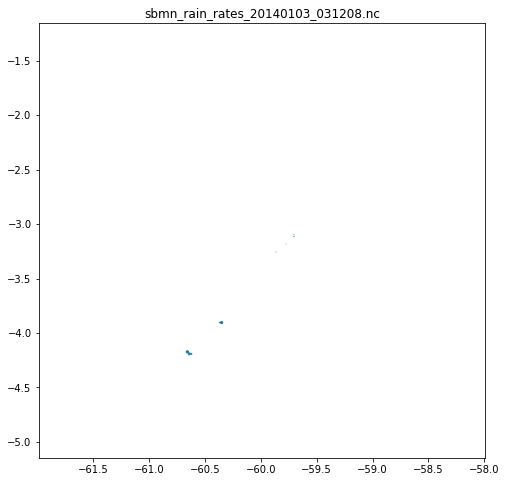

In [7]:
## Plot simple figure from dataset

figtime = 0

filename = sorted(os.listdir(path+str(day)))[figtime]

plt.figure(figsize=(8,8))
plt.title(filename)
plt.scatter(lon,lat,frames[figtime])
#plt.pcolormesh(lon,lat,frames[figtime])

#### 1.7 Clusterization

In [15]:
def pre_processing(time1):
    
    dx ,dy = [],[]
    
    for i in range(241):
        for j in range(241):
            if not np.isnan(time1[i][j]) and time1[i][j] > 10:
                dx.append(i)
                dy.append(j)

    dim = len(dx)
    
    # Check dimension
    if dim > 4:   
        for x in range(dim):
            dx.append(np.float32('nan'))
            dy.append(np.float32('nan'))

        matrix = np.ndarray(shape=(dim, 2), dtype='float32')
        pt = pd.DataFrame(columns=['x1','y1','rain_fall'])
    
        for x in range(dim):
            matrix[x] = (dx[x], dy[x])
            pt['x1'] = matrix[:,0]
            pt['y1'] = matrix[:,1]
            
        rfl= []
        for i,row in pt.iterrows():
            aux = time1[int(row['x1'])][int(row['y1'])]
            rfl.append(aux)
            
#         pt['rain_fall'] = (rfl)
        te = pt[['x1','y1']]
        
    return te

In [16]:
data = readData(day)
proc = pre_processing(data[0])
proc.head()

UnboundLocalError: local variable 'te' referenced before assignment

In [ ]:
def clust(time1):    #11.53:
    
    te = time1
          
    bandwidth = estimate_bandwidth(te, quantile=0.1)
    
    if bandwidth > 0:
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=None, cluster_all=True, min_bin_freq=1,
    n_jobs=None, seeds=None)
    else:
        ms = MeanShift(bandwidth=10, bin_seeding=None, cluster_all=True, min_bin_freq=1,
    n_jobs=None, seeds=None)

    ms.fit(te)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
        
#     colors = 10*['r.','g.','b.','c.','k.','y.','m.']
#     for i in range(len(te)):
#            #print(te['x1'][i])
#         plt.plot(te['x1'][i], te['y1'][i], colors[labels[i]], markersize = 10)
#         plt.title('Estimated number of clusters: %d' % n_clusters_)

#     kmeans = KMeans(n_clusters=8).fit(te)
#     labels = kmeans.labels_
#     cluster_centers = kmeans.cluster_centers_
#     n_clusters_ = len(np.unique(labels))

    te['cluster']=labels
    
    return te

In [ ]:
data = readData(day)
proc = pre_processing(data[2])

clusters = clust(proc)
clusters.head()

In [ ]:
def createData(time,clusters):
    
    if isinstance(clusters,pd.DataFrame):
        
        ##Static Radar Coordinates Value for Topological relation
        radar = (-3.148556, -59.992000)

        FAM1 = pd.DataFrame(columns=['YEAR','MONTH','DAY','HOUR','MINUTE',
                                     'N_Cluster','ID_CLUS','LAT','LON','IND_X','IND_Y',
                                     'T_RELATION','RAIN_FALL','DBz'])

        LAT_ = (lat[clusters['x1'].astype(int),clusters['y1'].astype(int)])
        LON_ = (lon[clusters['x1'].astype(int),clusters['y1'].astype(int)])
        N_CLUST = len(clusters['cluster'].unique())

        rfall = []
        rlation = []
        
        for i,row in clusters.iterrows():
            x_1, x_2 = row['x1'].astype(int), row['y1'].astype(int)
            rfall.append(frames[time][x_1][x_2])
            r = tRelation((LAT_[i],LON_[i]),radar)   ### Topological Relation
            rlation.append(r)

        FAM1['IND_X'], FAM1['IND_Y'] = clusters['x1'],clusters['y1']
        FAM1['LAT'],FAM1['LON'] = LAT_,LON_
        FAM1['N_Cluster'] = N_CLUST
        FAM1['ID_CLUS'] = clusters['cluster']
        FAM1['RAIN_FALL'] = rfall
        FAM1['T_RELATION'] = rlation
        FAM1['DBz'] =  10 * np.log10(200*FAM1['RAIN_FALL']**1.6)           ### Reflectivity = 10*log10(200R1.6)
        FAM1['YEAR'] = str(sorted(os.listdir(path+str(day)))[time])[16:20]
        FAM1['MONTH'] = str(sorted(os.listdir(path+str(day)))[time])[20:22]
        FAM1['DAY'] = str(sorted(os.listdir(path+str(day)))[time])[22:24]
        FAM1['HOUR'] = str(sorted(os.listdir(path+str(day)))[time])[25:27]
        FAM1['MINUTE'] = str(sorted(os.listdir(path+str(day)))[time])[27:29]
        
    else:
        return None

    return FAM1

In [ ]:
data = readData(day)
proc = pre_processing(data[0])
clusters = clust(proc)

createData(0,clusters).head()

In [ ]:
def centroidData(clus):
    
    if isinstance(clus,pd.DataFrame):
        centroid = pd.DataFrame()
        for i in range(clus['N_Cluster'].max()):
            ct = clus.loc[clus['ID_CLUS'] == i ]
            ct = ct.loc[ct['RAIN_FALL'] == ct['RAIN_FALL'].max()]
            centroid = centroid.append(ct)
    else:
        return None
    return centroid

In [ ]:
data = readData(day)
proc = pre_processing(data[0])
clusters = clust(proc)
cdata = createData(0,clusters)
centroidData(cdata)

In [ ]:
def tRelation(p,q):

    north_west       =  p[1] <  q[1] and  p[0] >  q[0] 
    restricted_north =  p[1] == q[1] and  p[0] >  q[0]
    north_east       =  p[1] >  q[1] and  p[0] >  q[0]
    restricted_west  =  p[1] <  q[1] and  p[0] == q[0]
    same_position    =  p[1] == q[1] and  p[0] == q[0]
    restricted_east  =  p[1] >  q[1] and  p[0] == q[0]
    south_west       =  p[1] <  q[1] and  p[0] <  q[0]
    restricted_south =  p[1] == q[1] and  p[0] <  q[0] 
    south_est        =  p[1] >  q[1] and  p[0] <  q[0]

    if north_west == True:
        return ('NW')
    if restricted_north == True:
        return ('RN')
    if north_east == True:
        return ('NE')
    if restricted_west == True:
        return ('RW')
    if same_position == True:
        return('SP')
    if restricted_east == True:
        return ('RE')
    if south_west == True:
        return ('SW')
    if restricted_south == True:
        return ('RS')
    if south_est == True:
        return ('SE')

In [ ]:
x1,y1 = -1.9451030492782593,-61.034568786621094      #-61.034568786621094 -1.9451030492782593
r1,r2 = -3.148556, -59.992000                  # RADAR
p = (x1,y1)                                    #PONTO
q = (r1,r2)                                    #RADAR

north_west       =  p[1] <  q[1] and  p[0] >  q[0] 
restricted_north =  p[1] == q[1] and  p[0] >  q[0]
north_east       =  p[1] >  q[1] and  p[0] >  q[0]
restricted_west  =  p[1] <  q[1] and  p[0] == q[0]
same_position    =  p[1] == q[1] and  p[0] == q[0]
restricted_east  =  p[1] >  q[1] and  p[0] == q[0]
south_west       =  p[1] <  q[1] and  p[0] <  q[0]
restricted_south =  p[1] == q[1] and  p[0] <  q[0] 
south_est        =  p[1] >  q[1] and  p[0] <  q[0]

print('NW',north_west)
print('RN',restricted_north)
print('NE',north_east)
print('RW',restricted_west)
print('SP',same_position)
print('RE',restricted_east)
print('SW',south_west)
print('RS',restricted_south)
print('SE',south_est)

#### 1.8 Pre-processing

In [ ]:
def run():
    data = readData(day)
    dados = pd.DataFrame()
    
    for i in range(len(data)):
        proc = pre_processing(data[i]) 
        cluster = clust(proc)
             
        if isinstance(cluster,pd.DataFrame):
            clt = createData(i,cluster)
            clt2 = centroidData(clt)
            dados = dados.append(clt2)
        else:
            pass     
    dados.to_csv('output/Moderate_Centroid_OUTPUT_'+str(sorted(os.listdir(path+str(day)))[i][:-3])+'.csv')

### RUN PROCESS

In [ ]:
run()

In [ ]:
data = readData(day)
proc = pre_processing(data[0])
clusters = clust(proc)
cdata = createData(0,clusters)
centroid = centroidData(cdata)

In [ ]:
setupMap(1)

In [ ]:
def setupMap(frame):

    data = readData(day)
    proc = pre_processing(data[frame])
    clusters = clust(proc)
    cdata = createData(frame,clusters)
    centers = centroidData(cdata)

    if isinstance(centers,pd.DataFrame):
        c_lat = centers['LAT']
        c_lon = centers['LON']

        centroid = []
        ## Set centroid of clusters by MAX RAIN_FALL Rate
        for i in range(centers['N_Cluster'].max()):
            ct = centers.loc[centers['ID_CLUS'] == i ]
            ct = ct.loc[ct['RAIN_FALL'] == ct['RAIN_FALL'].max()]
            centroid.append(ct)

    file = path+str(day)+'/'+str(sorted(os.listdir(path+str(day)))[frame])
    xds = xr.open_dataset(file)
    date_time = xds.start_time.data
    date_time = pd.to_datetime(date_time)
    
    my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
    zoom_scale = 2.2                        ## ZOOM SCALE

    bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
             my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]


    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
    label = 'Rain rate in ' + runit+ ''
    title = 'SIPAM Manaus S-Band Radar :' + str(date_time)

    # draw filled contours.
    clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
                 50, 70, 100]

    cmap_data = [(1.0, 1.0, 1.0),
                     (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                     (0.0, 1.0, 1.0),
                     (0.0, 0.8784313797950745, 0.501960813999176),
                     (0.0, 0.7529411911964417, 0.0),
                     (0.501960813999176, 0.8784313797950745, 0.0),
                     (1.0, 1.0, 0.0),
                     (1.0, 0.6274510025978088, 0.0),
                     (1.0, 0.0, 0.0),
                     (1.0, 0.125490203499794, 0.501960813999176),
                     (0.9411764740943909, 0.250980406999588, 1.0),
                     (0.501960813999176, 0.125490203499794, 1.0),
                     (0.250980406999588, 0.250980406999588, 1.0)]

    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)
    ax = axes

    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

    ## PRECIPTACAO
    xi, yi = m(lon, lat)
    ## SIPAM RADAR
    xm, ym = m(my_coords[1],my_coords[0])
    radar = m.plot(xm,ym, marker='^',color='r', label='RADAR')


    for cent in range(len(centroid)):
        clat, clon, mm_f = centroid[cent]['LAT'].item(),centroid[cent]['LON'].item(),centroid[cent]['RAIN_FALL'].item()
        t3x,t3y = m(clon, clat)
        m.plot(t3x,t3y, marker=markers.CARETDOWN, markersize=10, color='k')
#         plt.annotate(str(mm_f)[0:5]+'mm/h', xy=(t3x,t3y),xytext=(t3x+12,t3y+12),rotation=45, size=10)

    m.plot(xm,ym, label='Nº Clusters: ' +str(len(centroid)),marker=markers.CARETDOWN, color='k')

    cs = m.pcolormesh(xi,yi,data[frame], cmap = cmap, norm = norm, ax=ax)

    # # # # Add Grid Lines
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(7))
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(7))
    m.drawmapboundary(fill_color='gray')

    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    #m.fillcontinents(color='#FAFAFA',lake_color='dodgerblue')
    #m.drawlsmask(land_color='Linen', lake_color='#CCFFFF')
    m.drawrivers(color = '#0043CB', linewidth=1)

    #m.readshapefile('./data/am_municipios/13MUE250GC_SIR', 'teste')
    # # # # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")
    cbar.set_label(label)

    # # # # # Add Title
    plt.title(title)
    plt.legend()
    plt.ylabel('Longitude', labelpad=40)
    plt.xlabel('Latitude', labelpad=60)

    plt.savefig('radar_image/'+ sorted(os.listdir(path+str(day)))[frame]+'.png')

    plt.show()

In [ ]:
setupMap(0)

In [ ]:
## CREATE ALL FIGS
for i in range(len(frames)):
    setupMap(i)

#### Statistics

In [ ]:
path_output = 'output/rodada_mes_01/'

dados = []

for file in (sorted(os.listdir(path_output))):
    df = pd.read_csv(path_output+file)
    dados.append(df)

frames = dados[:]
janeiro = pd.concat(frames)

In [ ]:
month_rainfall = janeiro['RAIN_FALL']
month_dbz = janeiro['DBz']
days = janeiro['DAY']

In [ ]:
sns.set(style='darkgrid')
sns.lineplot(x=janeiro['DAY'],y=janeiro['RAIN_FALL'],label='Rain Fall Total')

In [ ]:
sns.lineplot(data=day1)

In [ ]:
plt.scatter(x,y,rain_fall)

In [ ]:
plt.scatter(x,y,dbz)

#### Function for create Animation (Giff File in root dir)

#### RESULTS

#### CONCLUSIONS

#### REFERENCES